In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt

# Ensure project root on sys.path for local imports when running directly
try:
    HERE = os.path.dirname(os.path.abspath(__file__))  # type: ignore[name-defined]
except NameError:
    HERE = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(HERE, ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from cls import WMEnv
from cls.utils.GridUtils import VectorHash
from cls.envs.environments import GridWMEnv
from cls.vectorhash.seq_utils import *
from cls.vectorhash.assoc_utils_np import *
from cls.vectorhash.senstranspose_utils import *
from  cls.vectorhash.assoc_utils_np_2D import gen_gbook_2d, path_integration_Wgg_2d, module_wise_NN_2d

seed = 3
rng = np.random.default_rng(seed)

In [17]:
# Initialize a pool of environments with fixed goals per env
# NOT USEFUL RIGHT NOW, DON'T NEED SCAFFOLD AT ALL
seed = 1
size = 10
speed = 1
num_envs = 2
rng = np.random.RandomState(seed)
env_pool = []
Np = 1000
lambdas = [6,7,9]
input_type = "g"
observation_size = 512

print("Setting up VectorHash")
vectorhash = VectorHash(Np=Np, lambdas=lambdas, size=size)

print("Setting up Envs")
for i in range(num_envs):
    env_i = GridWMEnv(size=size, speed=speed, seed=int(rng.randint(0, 10_000_000)), observation_size=observation_size, input_type=input_type, start_type="corner")
    env_pool.append(env_i)

vectorhash.initiate_vectorhash(env_pool)
env = env_pool[0]
gbook = vectorhash.gbook
path_sbook = vectorhash.path_sbook
path_gbook = vectorhash.path_gbook
env_locations = vectorhash.env_locations #corner locations for each environment

print(vectorhash.grid_onehot_to_indices(gbook[:, 0, 0])) # indices of ecah phase
print(vectorhash.get_loc_from_grid_state(gbook[:, 0, 0])) # location in enivronment

Setting up VectorHash
Setting up Envs
   setup scaffold
      gen_gbook_2d
(1000, 166)
(166, 378, 378)
      pbook
(1000, 378, 378)
      train_gcpc
(166, 1000)
   setup envs
   initialize envs vh


In [104]:
def train_hebbian(patterns):
    """
    patterns: array of shape (P, N), each in {0,1}
    Returns: weight matrix W with zero diagonal, using centered Hebbian rule.
    """
    P, N = patterns.shape
    # Center the patterns around 0.5 so that mean activity ~0
    centered = patterns - 0.5
    W = (centered.T @ centered) / N
    np.fill_diagonal(W, 0.0)
    return W

def recall(state, W, b, steps=10):
    s = state.astype(int).copy()
    for _ in range(steps):
        h = W @ s + b
        s = (h >= 0).astype(int)
    return s


def recall_async(state, W, b, steps=10, rng=None, track_energy=False):
    s = state.astype(int).copy()
    N = len(s)
    rng = np.random.default_rng() if rng is None else rng
    energies = [] if track_energy else None

    def energy(s):
        # Binary Hopfield energy (up to constant)
        return -0.5 * s @ W @ s - b @ s

    for _ in range(steps):
        order = rng.permutation(N)
        for i in order:
            h_i = W[i] @ s + b[i]
            s[i] = 1 if h_i >= 0 else 0
        if track_energy:
            energies.append(energy(s))

    if track_energy:
        return s, energies
    return s
    
def overlaps(x, y, px, py, size, touch_ok=True):
    if touch_ok:
        # touching edges allowed
        return not (x + size <= px or px + size <= x or y + size <= py or py + size <= y)
    else:
        # touching counts as overlap
        return not (x + size <  px or px + size <  x or y + size <  py or py + size <  y)

In [132]:
lambdas = [4,5]
Ng = np.sum(np.square(lambdas))
Npos = np.prod(lambdas)
gbook = gen_gbook_2d(lambdas, Ng, Npos)

In [133]:
n_envs = 2
size = 3

used = []  # store placed (x, y)
C_pairs = []
max_tries = 10_000  # guard against infinite loops
touch_ok = False      # set False to forbid touching
tries = 0
while len(C_pairs) < n_envs and tries < max_tries:
    x = np.random.randint(0, Npos - size + 1)
    y = np.random.randint(0, Npos - size + 1)
    if all(not overlaps(x, y, px, py, size, touch_ok) for (px, py) in used):
        used.append((x, y))
        C_pairs.append((x, y))
    tries += 1

In [134]:
C_pairs

[(9, 9), (11, 16)]

In [135]:
all_env_indices = []
goal_states = []
for env_idx in range(n_envs):
    C_X, C_Y = C_pairs[env_idx]
    x, y = np.meshgrid(np.arange(size), np.arange(size), indexing='ij')
    env_indices = np.stack((C_X + x, C_Y + y), axis=-1)
    all_env_indices.append(env_indices)

    flat_env = env_indices.reshape(-1, 2)
    goal_loc = flat_env[np.random.choice(len(flat_env))]
    goal_states.append(gbook[:, goal_loc[0], goal_loc[1]])

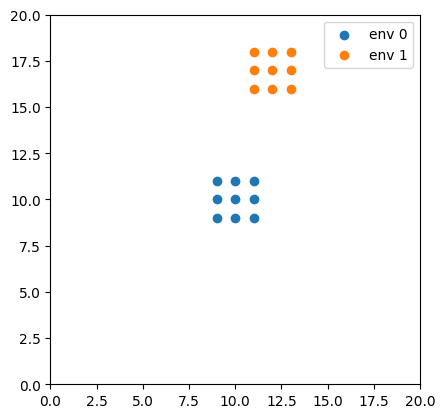

In [136]:
width, height = Npos, Npos

for env_idx in range(n_envs):
    env_indices = all_env_indices[env_idx]
    pos = env_indices.reshape(-1, 2)
    plt.scatter(pos[:, 0], pos[:, 1], label=f"env {env_idx}")

plt.xlim(0, width)
plt.ylim(0, height)
plt.gca().set_aspect('equal', adjustable='box')  # keep the aspect ratio square
plt.legend()
plt.show()

In [137]:
memories = np.stack(goal_states)
print(memories.shape)
W = train_hebbian(memories)
b = -W @ np.full(W.shape[0], 0.5)

(2, 41)


In [138]:
np.testing.assert_allclose(W, W.T, atol=1e-8)
assert np.allclose(np.diag(W), 0.0)

[9 9]


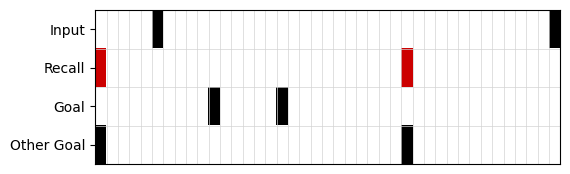

[ 9 10]


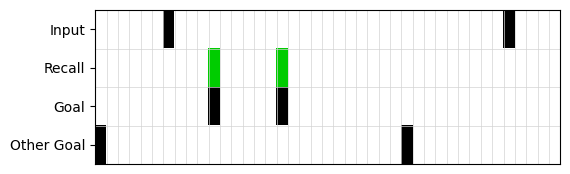

[ 9 11]


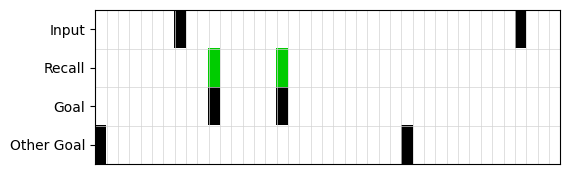

[10  9]


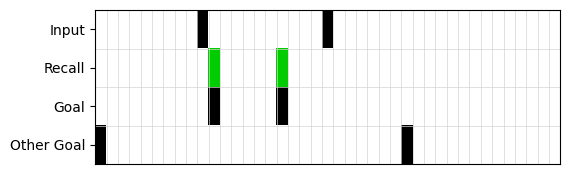

[10 10]


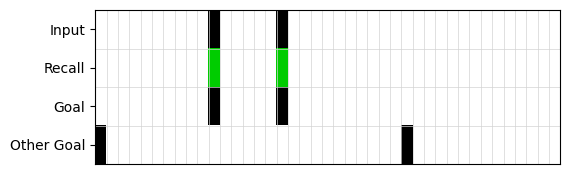

[10 11]


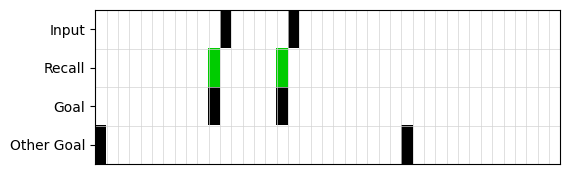

[11  9]


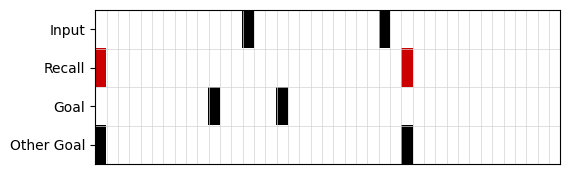

[11 10]


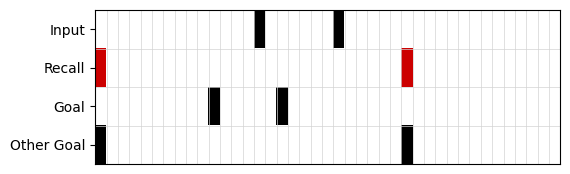

[11 11]


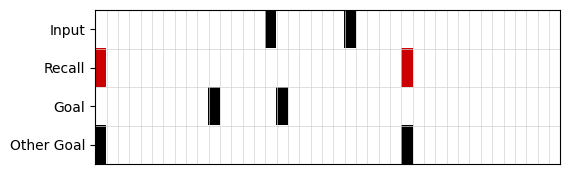

Env 0 accuracy: 5 / 9
[11 16]


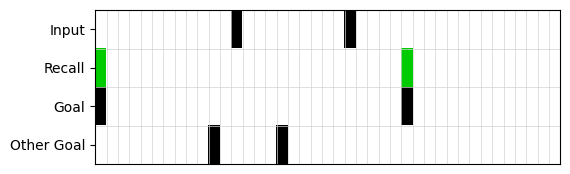

[11 17]


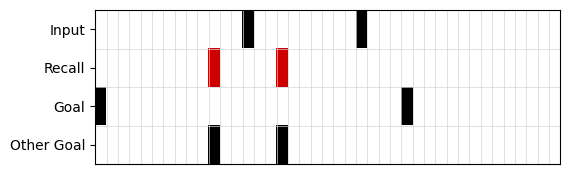

[11 18]


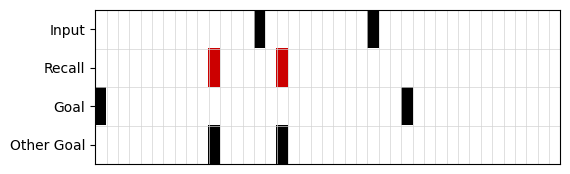

[12 16]


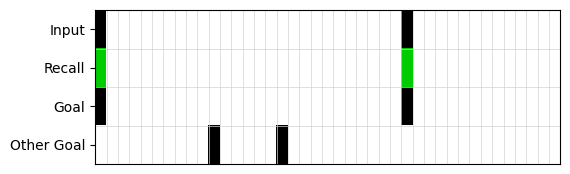

[12 17]


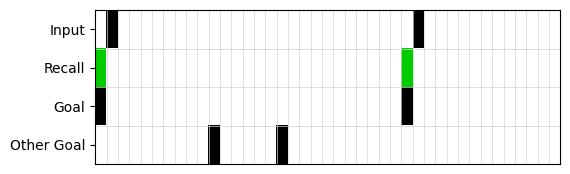

[12 18]


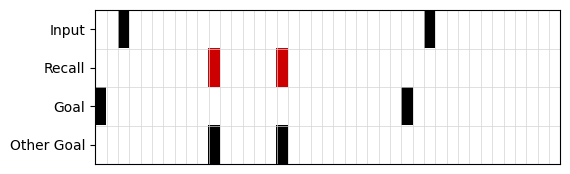

[13 16]


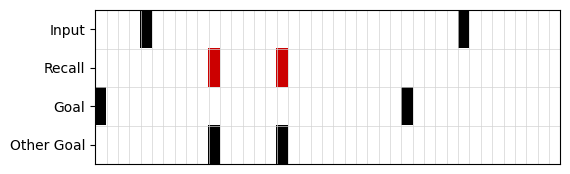

[13 17]


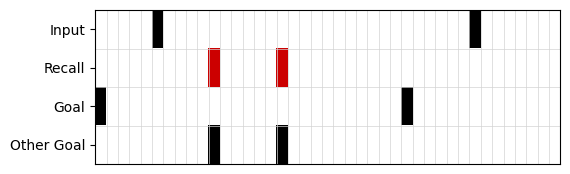

[13 18]


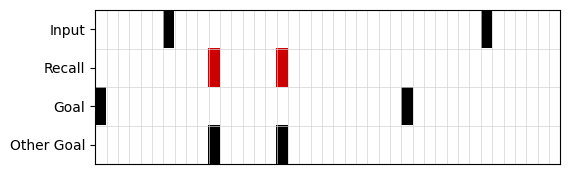

Env 1 accuracy: 3 / 9


In [143]:
def plot_results(target, other_target, g, recovered):
    # stack everything into a 4xN binary array
    data = np.vstack([g, recovered, target, other_target]).astype(float)
    n_rows, n_cols = data.shape

    # base grayscale image (white=0, black=1)
    img = np.repeat(data[:, :, None], 3, axis=2)  # RGB
    img = 1 - img  # make 1 -> black, 0 -> white for consistency with Greys cmap

    # determine color of the recall row (index 1)
    if np.array_equal(recovered, target):
        recall_color = np.array([0.0, 1.0, 0.0])  # green
    elif np.array_equal(recovered, other_target):
        recall_color = np.array([1.0, 0.0, 0.0])  # red
    else:
        recall_color = np.array([1.0, 0.5, 0.0])  # orange

    # apply color tint to the recall row (where bits are 1 / black)
    recall_mask = data[1] > 0.5
    img[1, recall_mask, :] = recall_color * 0.8  # colored cells (dim a bit)
    img[1, ~recall_mask, :] = 1.0  # white background for zeros

    # plot
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.imshow(img, aspect="auto", interpolation="none")

    ax.set_yticks(np.arange(n_rows))
    ax.set_yticklabels(["Input", "Recall", "Goal", "Other Goal"])
    ax.set_xticks([])

    # grid lines
    ax.set_xticks(np.arange(-0.5, n_cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, n_rows, 1), minor=True)
    ax.grid(which="minor", color="lightgray", linestyle="-", linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    plt.show()

    
for env_idx in range(n_envs):
    target = memories[env_idx]
    other_target = memories[1-env_idx]
    env_indices = all_env_indices[env_idx]
    correct = 0

    for x in range(size):
        for y in range(size):
            location = env_indices[x, y]
            g = gbook[:, location[0], location[1]]
            recovered, energies = recall_async(g, W, b, steps=10, track_energy=True)

            print(location)
            plot_results(target, other_target, g, recovered)

            # # --- Plot energies ---
            # fig, ax = plt.subplots(figsize=(5, 1))
            # plt.plot(energies)
            # plt.xlabel("Sweep")
            # plt.ylabel("Energy")
            # plt.title("Asynchronous Hopfield recall energy trajectory")
            # plt.show()

            if np.all(recovered == target):
                correct += 1

    print(f"Env {env_idx} accuracy: {correct} / {size**2}")

In [1]:
import sys
print(sys.prefix)
print(sys.executable)

/om2/user/jackking/conda/envs/cls
/om2/user/jackking/conda/envs/cls/bin/python


In [55]:
# --------- Demo: add patterns sequentially ----------
rng = np.random.default_rng(0)
N, P = 100, 2

# Random binary memories
memories = rng.integers(0, 2, size=(P, N))

# Initialize from scratch: W = 0, then train
W = train_hebbian(memories)
b = -W @ np.full(W.shape[0], 0.5)

# Choose one memory and corrupt 20%
target = memories[0]
flip_mask = rng.random(N) < 0.2
cue = target.copy()
cue[flip_mask] = 1 - cue[flip_mask]

rec = recall(cue, W, b, steps=10)

print("Match to target (sync): ", (rec  == target).mean())

Match to target (sync):  1.0
